In [109]:
import pandas as pd
import seaborn as sns
import json
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules
from functools import reduce
from collections import OrderedDict

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

# Importing data

In [38]:
canada_hospital_1 = pd.read_excel("./data/uncover/Canada_Hosp_COVID19_Inpatient_DatasetDefinitions/Canada_Hosp1_COVID_InpatientData.xlsx")
canada_hospital_2 = pd.read_excel("./data/uncover/Canada_Hosp_COVID19_Inpatient_DatasetDefinitions/Canada_Hosp2_COVID_InpatientData.xlsx")
canada_hospital = pd.concat([canada_hospital_1, canada_hospital_2])

In [39]:
canada_hospital.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709 entries, 0 to 200
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                709 non-null    float64
 1   reason_for_admission              707 non-null    object 
 2   age                               709 non-null    float64
 3   sex                               706 non-null    object 
 4   ethnicity                         709 non-null    object 
 5   ethnicity_other                   58 non-null     object 
 6   height                            297 non-null    float64
 7   weight                            389 non-null    float64
 8   comorbidities                     709 non-null    object 
 9   comorbidities_other               521 non-null    object 
 10  received_covid_vaccine            188 non-null    object 
 11  covid_vaccine                     1 non-null      object 
 12  medicati

# Preprocessing

## Fix missing values

In [40]:
canada_hospital[canada_hospital["sex"].isnull()]

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,received_covid_vaccine,covid_vaccine,medications,smoking_history,year_they_quit,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,intubated,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,pao2,pao2_fio2,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp
36,37.0,COVID-19,77.0,NaN,"""[]""",NaN,NaN,NaN,"""[]""","Obstructive sleep apnea, hiatus hernia, GERD, dyslipidemia, depression/anxiety",NaN,NaN,"""[{\""medications\"":\""atorvastati\"",\""dosage\"":\""20\"",\""frequency\"":\""Please Select an option\""}]""",Ex-smoker,1986.0,No,WARD,92.0,42.0,83.0,22.0,95.0,37.4,NaN,NaN,NaN,NaN,4.7,4.74,145.0,0.421,88.7,30.6,345.0,13.5,181.0,NaN,11.7,18.0,NaN,75.0,141.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.07,NaN,NaN,NaN,NaN
55,56.0,COVID-19 positive,57.0,NaN,"""[]""",NaN,NaN,NaN,"""[]""",NaN,NaN,NaN,"""[{\""medications\"":\""GABAPENTIN\"",\""dosage\"":\""\"",\""frequency\"":\""OD\""},{\""medications\"":\""Codeine\"",\""dosage\"":\""\"",\""frequency\"":\""OD\""},{\""medications\"":\""VALACYCLOVIR\"",\""dosage\"":\""\"",\""frequency\"":\""OD\""}]""",Ex-smoker,NaN,No,ICU,112.0,75.0,104.0,44.0,92.0,38.0,NaN,NaN,NaN,Yes,7.6,4.20,132.0,0.388,92.4,31.5,341.0,15.0,252.0,NaN,NaN,26.0,NaN,97.0,132.0,4.4,7.0,2.3,NaN,NaN,7.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,109.0,"Presented to ED with neutropenic fever, COVID-19 Admission",71.0,NaN,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\"",\""Cancer [active only]\"",\""Diabetes\"",\""Other\""]""",NaN,No,NaN,"""[{\""medications\"":\""RAMIPRIL\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""},{\""medications\"":\""ROSUVASTATIN\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""},{\""medications\"":\""amiodipine\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""},{\""medications\"":\""apixaban\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""}]""",Non-smoker,NaN,No,WARD,117.0,72.0,113.0,24.0,98.0,38.4,NaN,NaN,NaN,No,0.2,2.86,82.0,0.243,85.0,28.7,338.0,13.6,52.0,NaN,NaN,108.0,NaN,NaN,137.0,3.8,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
canada_hospital["sex"] = canada_hospital["sex"].fillna("Other Gender")

In [42]:
canada_hospital.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709 entries, 0 to 200
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                709 non-null    float64
 1   reason_for_admission              707 non-null    object 
 2   age                               709 non-null    float64
 3   sex                               709 non-null    object 
 4   ethnicity                         709 non-null    object 
 5   ethnicity_other                   58 non-null     object 
 6   height                            297 non-null    float64
 7   weight                            389 non-null    float64
 8   comorbidities                     709 non-null    object 
 9   comorbidities_other               521 non-null    object 
 10  received_covid_vaccine            188 non-null    object 
 11  covid_vaccine                     1 non-null      object 
 12  medicati

## Filter only patients infected with Covid-19

In [43]:
canada_hospital = canada_hospital[canada_hospital["reason_for_admission"].notna()]

In [44]:
canada_hospital.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 707 entries, 0 to 200
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                707 non-null    float64
 1   reason_for_admission              707 non-null    object 
 2   age                               707 non-null    float64
 3   sex                               707 non-null    object 
 4   ethnicity                         707 non-null    object 
 5   ethnicity_other                   58 non-null     object 
 6   height                            297 non-null    float64
 7   weight                            389 non-null    float64
 8   comorbidities                     707 non-null    object 
 9   comorbidities_other               519 non-null    object 
 10  received_covid_vaccine            187 non-null    object 
 11  covid_vaccine                     1 non-null      object 
 12  medicati

In [45]:
canada_hospital.head()

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,received_covid_vaccine,covid_vaccine,medications,smoking_history,year_they_quit,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,intubated,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,pao2,pao2_fio2,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp
0,1.0,Fever [R50.9],74.0,Male,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""","GERD (gastroesophageal reflux disease), Dementia Depression, Barrett esophagus, Pneumonia, Schizophrenia, Hiatus Hernia, Reflux esophagitis",NaN,NaN,"""[{\""medications\"":\""TYLENOL EXTRA STRENGTH\"",\""dosage\"":\""325\"",\""frequency\"":\""OD\""},{\""medications\"":\""ROSUVASTATIN\"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""PANTOPRAZOLE\"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""NORVASC\"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""DULCOLAX\"",\""dosage\"":\""10\"",\""frequency\"":\""OD\""},{\""medications\"":\""WELLBUTRIN XL\"",\""dosage\"":\""300\"",\""frequency\"":\""OD\""},{\""medications\"":\""CHOLECALCIFEROL\"",\""dosage\"":\""1,000 UNITS\"",\""frequency\"":\""OD\""},{\""medications\"":\""CLOZAPINE\"",\""dosage\"":\""250\"",\""frequency\"":\""OD\""},{\""medications\"":\""FERROUS FUMARATE SCT TAB \"",\""dosage\"":\""300\"",\""frequency\"":\""OD\""},{\""medications\"":\""LACTULOSE\"",\""dosage\"":\""30 grams\"",\""frequency\"":\""BID\""},{\""medications\"":\""KEPPRA\"",\""dosage\"":\""500\"",\""frequency\"":\""BID\""},{\""medications\"":\""GLUCOPHAGE\"",\""dosage\"":\""250\"",\""frequency\"":\""BID\""},{\""medications\"":\""PANTOLOC\"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""CLEARLAX\"",\""dosage\"":\""17 grams\"",\""frequency\"":\""BID\""},{\""medications\"":\""ALTACE CAP \"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""CLOZAPINE\"",\""dosage\"":\""150\"",\""frequency\"":\""OD\""},{\""medications\"":\""CLOZAPINE\"",\""dosage\"":\""50\"",\""frequency\"":\""OD\""},{\""medications\"":\""SENEKOT\"",\""dosage\"":\""8.6/ 2 Tab\"",\""frequency\"":\""OD\""},{\""medications\"":\""SENEKOT\"",\""dosage\"":\""8.6/3 Tab\"",\""frequency\"":\""OD\""}]""",NaN,NaN,No,WARD,99.0,62.0,85.0,20.0,93.0,37.5,6.0,4.0,4.0,No,11.0,5.63,132.0,0.406,72.1,23.4,325.0,18.5,128.0,44.0,14.1,53.0,49.0,165.0,135.0,3.9,10.0,2.3,NaN,NaN,NaN,NaN,NaN,1.1,NaN,NaN,223.0,NaN
1,2.0,Pneumonia [J18.9],61.0,Female,"""[]""",NaN,154.9,73.6,"""[\""Hypertension\"",\""Other\""]""","Closed fracture of fifth metatarsal bone, Diverticulosis, Irritable bowel syndrome, Vertigo",NaN,NaN,"""[{\""medications\"":\""CANDESARTAN\"",\""dosage\"":\""8\"",\""frequency\"":\""OD\""}]""",NaN,NaN,No,WARD,122.0,77.0,93.0,36.0,88.0,38.0,6.0,5.0,4.0,No,5.0,4.49,121.0,0.353,78.6,26.9,343.0,14.2,236.0,28.0,12.9,68.0,68.0,49.0,137.0,3.8,12.0,1.5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2354.0,95.6,NaN
2,3.0,Pneumonia [J18.9],58.0,Female,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\""]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":\""OD\""}]""",NaN,NaN,No,WARD,109.0,72.0,73.0,24.0,91.0,38.3,6.0,5.0,3.0,No,6.2,4.31,119.0,0.362,84.0,27.6,329.0,12.5,249.0,NaN,NaN,52.0,76.0,71.0,135.0,3.7,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,Suspected COVID-19 virus infection [U07.2],94.0,Male,"""[]""",NaN,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostatic Hyperplasia, Cholecystitis, Chronic Kidney Disease, Fall, Gastroesophageal reflux disease, Gout, History of total hip replacement left hip, Osteoporosis,",NaN,NaN,"""[{\""medications\"":\""ACETYLSALICYLIC ACID TAB\"",\""dosage\"":\""81\"",\""f

In [46]:
canada_hospital_covid19 = canada_hospital[canada_hospital["reason_for_admission"].str.contains("covid", case=False)]

In [47]:
canada_hospital_covid19.head()

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,received_covid_vaccine,covid_vaccine,medications,smoking_history,year_they_quit,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,intubated,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,pao2,pao2_fio2,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp
3,4.0,Suspected COVID-19 virus infection [U07.2],94.0,Male,"""[]""",NaN,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostatic Hyperplasia, Cholecystitis, Chronic Kidney Disease, Fall, Gastroesophageal reflux disease, Gout, History of total hip replacement left hip, Osteoporosis,",NaN,NaN,"""[{\""medications\"":\""ACETYLSALICYLIC ACID TAB\"",\""dosage\"":\""81\"",\""frequency\"":\""OD\""},{\""medications\"":\""ZYLOPRIM \"",\""dosage\"":\""300\"",\""frequency\"":\""OD\""},{\""medications\"":\""CHOLECALCIFEROL\"",\""dosage\"":\""1000\"",\""frequency\"":\""OD\""},{\""medications\"":\""PROSCAR\"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""LASIX TABS \"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""HYDROMORPHONE\"",\""dosage\"":\""12\"",\""frequency\"":\""BID\""},{\""medications\"":\""SINEMET\"",\""dosage\"":\""100-25\"",\""frequency\"":\""QUID\""},{\""medications\"":\""REMERON\"",\""dosage\"":\""30\"",\""frequency\"":\""OD\""},{\""medications\"":\""PANTOPRAZOLE\"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""SENOKOT\"",\""dosage\"":\""16.12\"",\""frequency\"":\""OD\""},{\""medications\"":\""IMOVANE\"",\""dosage\"":\""3.75\"",\""frequency\"":\""PRN\""}]""",NaN,NaN,No,WARD,165.0,71.0,92.0,16.0,96.0,37.5,6.0,5.0,4.0,No,5.2,4.18,137.0,0.428,102.4,32.8,320.0,17.2,98.0,NaN,NaN,6.0,24.0,146.0,135.0,2.8,10.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7.0,COVID-19 [U07.1],50.0,Male,"""[]""",NaN,188.0,91.1,"""[]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",NaN,NaN,No,WARD,149.0,100.0,130.0,20.0,94.0,39.4,6.0,5.0,4.0,No,10.8,5.59,158.0,0.467,83.5,28.3,338.0,13.3,271.0,NaN,NaN,40.0,35.0,69.0,134.0,3.8,10.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<270,49.5,NaN
10,11.0,COVID-19 [U07.1],57.0,Male,"""[]""",NaN,178.0,58.0,"""[]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",Ex-smoker,NaN,No,WARD,111.0,68.0,113.0,20.0,92.0,38.0,6.0,5.0,4.0,No,4.2,5.21,153.0,0.450,86.4,29.4,340.0,12.7,109.0,NaN,NaN,47.0,40.0,81.0,133.0,4.0,12.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,12.0,COVID-19 [U07.1],76.0,Female,"""[]""",NaN,162.0,72.6,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""",Hypercholesteremia,NaN,NaN,"""[{\""medications\"":\""Citalopram \"",\""dosage\"":\""20\"",\""frequency\"":\""OD\""},{\""medications\"":\""Atenolol \"",\""dosage\"":\""25\"",\""frequency\"":\""OD\""},{\""medications\"":\""Trazodone \"",\""dosage\"":\""50\"",\""frequency\"":\""OD\""},{\""medications\"":\""Crestor \"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""Ramipril \"",\""dosage\"":\""5\"",\""frequency\"":\""BID\""}]""",Non-smoker,NaN,No,WARD,138.0,74.0,60.0,20.0,93.0,38.4,6.0,5.0,4.0,No,4.3,4.52,133.0,0.388,85.8,29.4,343.0,12.1,133.0,NaN,NaN,29.0,42.0,90.0,132.0,4.3,20.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1744.0,111.0,NaN
12,13.0,COVID-19 [U07.1],86.0,Male,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\""]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""}]""",NaN,NaN,Yes,WARD,123.0,79.0,72.0,20.0,95.0,37.5,6.0,5.0,4.0,No,3.5,5.28,135.0,0.434,82.2,25.6,311.0,14.5,122.0,NaN,NaN,NaN,NaN,110.0,135.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Transform quantitative to categorical

### Age

In [48]:
age_ranges = [0, 17, 44, 64, 100]
age_labels = ["<18 years", "18-45 years", "45-65 years", ">65 years"]
canada_hospital_covid19["age"] = pd.cut(canada_hospital_covid19["age"], bins=age_ranges, labels=age_labels).astype(str)

/tmp/ipykernel_135647/2858373239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canada_hospital_covid19["age"] = pd.cut(canada_hospital_covid19["age"], bins=age_ranges, labels=age_labels).astype(str)


In [49]:
canada_hospital_covid19.head()

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,received_covid_vaccine,covid_vaccine,medications,smoking_history,year_they_quit,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,intubated,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,pao2,pao2_fio2,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp
3,4.0,Suspected COVID-19 virus infection [U07.2],>65 years,Male,"""[]""",NaN,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostatic Hyperplasia, Cholecystitis, Chronic Kidney Disease, Fall, Gastroesophageal reflux disease, Gout, History of total hip replacement left hip, Osteoporosis,",NaN,NaN,"""[{\""medications\"":\""ACETYLSALICYLIC ACID TAB\"",\""dosage\"":\""81\"",\""frequency\"":\""OD\""},{\""medications\"":\""ZYLOPRIM \"",\""dosage\"":\""300\"",\""frequency\"":\""OD\""},{\""medications\"":\""CHOLECALCIFEROL\"",\""dosage\"":\""1000\"",\""frequency\"":\""OD\""},{\""medications\"":\""PROSCAR\"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""LASIX TABS \"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""HYDROMORPHONE\"",\""dosage\"":\""12\"",\""frequency\"":\""BID\""},{\""medications\"":\""SINEMET\"",\""dosage\"":\""100-25\"",\""frequency\"":\""QUID\""},{\""medications\"":\""REMERON\"",\""dosage\"":\""30\"",\""frequency\"":\""OD\""},{\""medications\"":\""PANTOPRAZOLE\"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""SENOKOT\"",\""dosage\"":\""16.12\"",\""frequency\"":\""OD\""},{\""medications\"":\""IMOVANE\"",\""dosage\"":\""3.75\"",\""frequency\"":\""PRN\""}]""",NaN,NaN,No,WARD,165.0,71.0,92.0,16.0,96.0,37.5,6.0,5.0,4.0,No,5.2,4.18,137.0,0.428,102.4,32.8,320.0,17.2,98.0,NaN,NaN,6.0,24.0,146.0,135.0,2.8,10.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7.0,COVID-19 [U07.1],45-65 years,Male,"""[]""",NaN,188.0,91.1,"""[]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",NaN,NaN,No,WARD,149.0,100.0,130.0,20.0,94.0,39.4,6.0,5.0,4.0,No,10.8,5.59,158.0,0.467,83.5,28.3,338.0,13.3,271.0,NaN,NaN,40.0,35.0,69.0,134.0,3.8,10.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<270,49.5,NaN
10,11.0,COVID-19 [U07.1],45-65 years,Male,"""[]""",NaN,178.0,58.0,"""[]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",Ex-smoker,NaN,No,WARD,111.0,68.0,113.0,20.0,92.0,38.0,6.0,5.0,4.0,No,4.2,5.21,153.0,0.450,86.4,29.4,340.0,12.7,109.0,NaN,NaN,47.0,40.0,81.0,133.0,4.0,12.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,12.0,COVID-19 [U07.1],>65 years,Female,"""[]""",NaN,162.0,72.6,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""",Hypercholesteremia,NaN,NaN,"""[{\""medications\"":\""Citalopram \"",\""dosage\"":\""20\"",\""frequency\"":\""OD\""},{\""medications\"":\""Atenolol \"",\""dosage\"":\""25\"",\""frequency\"":\""OD\""},{\""medications\"":\""Trazodone \"",\""dosage\"":\""50\"",\""frequency\"":\""OD\""},{\""medications\"":\""Crestor \"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""Ramipril \"",\""dosage\"":\""5\"",\""frequency\"":\""BID\""}]""",Non-smoker,NaN,No,WARD,138.0,74.0,60.0,20.0,93.0,38.4,6.0,5.0,4.0,No,4.3,4.52,133.0,0.388,85.8,29.4,343.0,12.1,133.0,NaN,NaN,29.0,42.0,90.0,132.0,4.3,20.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1744.0,111.0,NaN
12,13.0,COVID-19 [U07.1],>65 years,Male,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\""]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""}]""",NaN,NaN,Yes,WARD,123.0,79.0,72.0,20.0,95.0,37.5,6.0,5.0,4.0,No,3.5,5.28,135.0,0.434,82.2,25.6,311.0,14.5,122.0,NaN,NaN,NaN,NaN,110.0,135.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

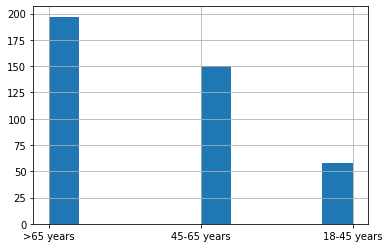

In [113]:
# ages = sns.load_dataset(canada_hospital_covid19["age"])
canada_hospital_covid19["age"].hist()

## Transform raw `comorbidities` data

### Major comorbidities

In [51]:
canada_hospital_covid19["comorbidities"] = canada_hospital_covid19["comorbidities"].map(lambda cell: list(map(lambda x: x.lower(), json.loads(json.loads(cell)))))

/tmp/ipykernel_135647/3735221934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canada_hospital_covid19["comorbidities"] = canada_hospital_covid19["comorbidities"].map(lambda cell: list(map(lambda x: x.lower(), json.loads(json.loads(cell)))))


In [52]:
canada_hospital_covid19.head()

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,received_covid_vaccine,covid_vaccine,medications,smoking_history,year_they_quit,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,intubated,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,pao2,pao2_fio2,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp
3,4.0,Suspected COVID-19 virus infection [U07.2],>65 years,Male,"""[]""",NaN,182.8,66.2,"[hypertension, other]","Parkinson's Disease, Back pain, Benign Prostatic Hyperplasia, Cholecystitis, Chronic Kidney Disease, Fall, Gastroesophageal reflux disease, Gout, History of total hip replacement left hip, Osteoporosis,",NaN,NaN,"""[{\""medications\"":\""ACETYLSALICYLIC ACID TAB\"",\""dosage\"":\""81\"",\""frequency\"":\""OD\""},{\""medications\"":\""ZYLOPRIM \"",\""dosage\"":\""300\"",\""frequency\"":\""OD\""},{\""medications\"":\""CHOLECALCIFEROL\"",\""dosage\"":\""1000\"",\""frequency\"":\""OD\""},{\""medications\"":\""PROSCAR\"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""LASIX TABS \"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""HYDROMORPHONE\"",\""dosage\"":\""12\"",\""frequency\"":\""BID\""},{\""medications\"":\""SINEMET\"",\""dosage\"":\""100-25\"",\""frequency\"":\""QUID\""},{\""medications\"":\""REMERON\"",\""dosage\"":\""30\"",\""frequency\"":\""OD\""},{\""medications\"":\""PANTOPRAZOLE\"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""SENOKOT\"",\""dosage\"":\""16.12\"",\""frequency\"":\""OD\""},{\""medications\"":\""IMOVANE\"",\""dosage\"":\""3.75\"",\""frequency\"":\""PRN\""}]""",NaN,NaN,No,WARD,165.0,71.0,92.0,16.0,96.0,37.5,6.0,5.0,4.0,No,5.2,4.18,137.0,0.428,102.4,32.8,320.0,17.2,98.0,NaN,NaN,6.0,24.0,146.0,135.0,2.8,10.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7.0,COVID-19 [U07.1],45-65 years,Male,"""[]""",NaN,188.0,91.1,[],NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",NaN,NaN,No,WARD,149.0,100.0,130.0,20.0,94.0,39.4,6.0,5.0,4.0,No,10.8,5.59,158.0,0.467,83.5,28.3,338.0,13.3,271.0,NaN,NaN,40.0,35.0,69.0,134.0,3.8,10.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<270,49.5,NaN
10,11.0,COVID-19 [U07.1],45-65 years,Male,"""[]""",NaN,178.0,58.0,[],NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",Ex-smoker,NaN,No,WARD,111.0,68.0,113.0,20.0,92.0,38.0,6.0,5.0,4.0,No,4.2,5.21,153.0,0.450,86.4,29.4,340.0,12.7,109.0,NaN,NaN,47.0,40.0,81.0,133.0,4.0,12.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,12.0,COVID-19 [U07.1],>65 years,Female,"""[]""",NaN,162.0,72.6,"[hypertension, diabetes, other]",Hypercholesteremia,NaN,NaN,"""[{\""medications\"":\""Citalopram \"",\""dosage\"":\""20\"",\""frequency\"":\""OD\""},{\""medications\"":\""Atenolol \"",\""dosage\"":\""25\"",\""frequency\"":\""OD\""},{\""medications\"":\""Trazodone \"",\""dosage\"":\""50\"",\""frequency\"":\""OD\""},{\""medications\"":\""Crestor \"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""Ramipril \"",\""dosage\"":\""5\"",\""frequency\"":\""BID\""}]""",Non-smoker,NaN,No,WARD,138.0,74.0,60.0,20.0,93.0,38.4,6.0,5.0,4.0,No,4.3,4.52,133.0,0.388,85.8,29.4,343.0,12.1,133.0,NaN,NaN,29.0,42.0,90.0,132.0,4.3,20.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1744.0,111.0,NaN
12,13.0,COVID-19 [U07.1],>65 years,Male,"""[]""",NaN,NaN,NaN,[hypertension],NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""}]""",NaN,NaN,Yes,WARD,123.0,79.0,72.0,20.0,95.0,37.5,6.0,5.0,4.0,No,3.5,5.28,135.0,0.434,82.2,25.6,311.0,14.5,122.0,NaN,NaN,NaN,NaN,110.0,135.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Other comorbidities

In [53]:
def transform_other_comorbidities(cell):
  if isinstance(cell, str):
    other_comorbidities = cell.rstrip(",").rstrip(".").replace("\t", "").lower().split(", ")

    return list(filter(lambda other_comorbidity: other_comorbidity != "", map(lambda other_comorbidity: other_comorbidity.strip().strip("\""), other_comorbidities)))
  else:
    return []

canada_hospital_covid19["comorbidities_other"] = canada_hospital_covid19["comorbidities_other"].map(transform_other_comorbidities)

/tmp/ipykernel_135647/3279958557.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canada_hospital_covid19["comorbidities_other"] = canada_hospital_covid19["comorbidities_other"].map(transform_other_comorbidities)


In [54]:
canada_hospital_covid19.head()

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,received_covid_vaccine,covid_vaccine,medications,smoking_history,year_they_quit,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,intubated,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,pao2,pao2_fio2,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp
3,4.0,Suspected COVID-19 virus infection [U07.2],>65 years,Male,"""[]""",NaN,182.8,66.2,"[hypertension, other]","[parkinson's disease, back pain, benign prostatic hyperplasia, cholecystitis, chronic kidney disease, fall, gastroesophageal reflux disease, gout, history of total hip replacement left hip, osteoporosis]",NaN,NaN,"""[{\""medications\"":\""ACETYLSALICYLIC ACID TAB\"",\""dosage\"":\""81\"",\""frequency\"":\""OD\""},{\""medications\"":\""ZYLOPRIM \"",\""dosage\"":\""300\"",\""frequency\"":\""OD\""},{\""medications\"":\""CHOLECALCIFEROL\"",\""dosage\"":\""1000\"",\""frequency\"":\""OD\""},{\""medications\"":\""PROSCAR\"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""LASIX TABS \"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""HYDROMORPHONE\"",\""dosage\"":\""12\"",\""frequency\"":\""BID\""},{\""medications\"":\""SINEMET\"",\""dosage\"":\""100-25\"",\""frequency\"":\""QUID\""},{\""medications\"":\""REMERON\"",\""dosage\"":\""30\"",\""frequency\"":\""OD\""},{\""medications\"":\""PANTOPRAZOLE\"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""SENOKOT\"",\""dosage\"":\""16.12\"",\""frequency\"":\""OD\""},{\""medications\"":\""IMOVANE\"",\""dosage\"":\""3.75\"",\""frequency\"":\""PRN\""}]""",NaN,NaN,No,WARD,165.0,71.0,92.0,16.0,96.0,37.5,6.0,5.0,4.0,No,5.2,4.18,137.0,0.428,102.4,32.8,320.0,17.2,98.0,NaN,NaN,6.0,24.0,146.0,135.0,2.8,10.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7.0,COVID-19 [U07.1],45-65 years,Male,"""[]""",NaN,188.0,91.1,[],[],NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",NaN,NaN,No,WARD,149.0,100.0,130.0,20.0,94.0,39.4,6.0,5.0,4.0,No,10.8,5.59,158.0,0.467,83.5,28.3,338.0,13.3,271.0,NaN,NaN,40.0,35.0,69.0,134.0,3.8,10.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<270,49.5,NaN
10,11.0,COVID-19 [U07.1],45-65 years,Male,"""[]""",NaN,178.0,58.0,[],[],NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",Ex-smoker,NaN,No,WARD,111.0,68.0,113.0,20.0,92.0,38.0,6.0,5.0,4.0,No,4.2,5.21,153.0,0.450,86.4,29.4,340.0,12.7,109.0,NaN,NaN,47.0,40.0,81.0,133.0,4.0,12.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,12.0,COVID-19 [U07.1],>65 years,Female,"""[]""",NaN,162.0,72.6,"[hypertension, diabetes, other]",[hypercholesteremia],NaN,NaN,"""[{\""medications\"":\""Citalopram \"",\""dosage\"":\""20\"",\""frequency\"":\""OD\""},{\""medications\"":\""Atenolol \"",\""dosage\"":\""25\"",\""frequency\"":\""OD\""},{\""medications\"":\""Trazodone \"",\""dosage\"":\""50\"",\""frequency\"":\""OD\""},{\""medications\"":\""Crestor \"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""Ramipril \"",\""dosage\"":\""5\"",\""frequency\"":\""BID\""}]""",Non-smoker,NaN,No,WARD,138.0,74.0,60.0,20.0,93.0,38.4,6.0,5.0,4.0,No,4.3,4.52,133.0,0.388,85.8,29.4,343.0,12.1,133.0,NaN,NaN,29.0,42.0,90.0,132.0,4.3,20.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1744.0,111.0,NaN
12,13.0,COVID-19 [U07.1],>65 years,Male,"""[]""",NaN,NaN,NaN,[hypertension],[],NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""}]""",NaN,NaN,Yes,WARD,123.0,79.0,72.0,20.0,95.0,37.5,6.0,5.0,4.0,No,3.5,5.28,135.0,0.434,82.2,25.6,311.0,14.5,122.0,NaN,NaN,NaN,NaN,110.0,135.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
all_other_comorbidities = reduce(lambda accum, row: accum + row, canada_hospital_covid19["comorbidities_other"], [])

unique_other_comorbidities = list(OrderedDict.fromkeys(all_other_comorbidities))
unique_other_comorbidities.sort()
unique_other_comorbidities

['(complex) ptsd by history',
 '0.77cm',
 '2011 lll removed',
 '49/24 peak/mean.  lvef 60%',
 'a-fib',
 'abdominal aneurysm',
 'abdominal aortic aneurysm',
 'abnormal finding on breast imaging patient had non diagnostic mammogram in 2020',
 'acid reflux',
 'acute myopericarditis - admitted for treatment in dec 2018. did not improve on nsaids and required steroids',
 'adhd',
 'adjustment disorder with anxiety',
 'advanced stage with history of bps.',
 'alcohol abuse',
 'and sleep apnea',
 'and subsequent us demonstrated indeterminant lesion',
 'anemia',
 'angina pectoris',
 'antisocial personality disorder',
 'anxiety',
 'anxiety and depression',
 'anxiety/depression',
 'aortic aneurysm',
 'aortic stenosis',
 'aortic stenosis echo dec 2020: mod-severe as',
 'aortic valve endocarditis',
 'appendectomy',
 'appendicitis',
 'arthritis',
 'assymmetric septal hypertrophy cmp with apical component - normal lvef of 58%',
 'atrial fib/flutter',
 'atrial fibrillation',
 'atrial flutter',
 'b12 de

In [56]:
# Fix similar meaning.
similar_comorbidities = {
  "aortic aneurysm": [
    "abdominal aneurysm"
    "abdominal aortic aneurysm",
  ],
  "abnormal finding on breast": [
    "abnormal finding on breast imaging patient had non diagnostic mammogram in 2020",
  ],
  "acid reflux": [],
  "acute myopericarditis": [],
  "adjustment disorder with anxiety": [],
  "alcohol abuse": [],
  "sleep apnea": [
    "and sleep apnea"
  ],
  "anemia": [],
  "angina pectoris": [],
  "antisocial": [],
  "anxiety": [
    "anxiety",
    "anxiety and depression", 
    "anxiety/depression",
  ],
}

def normalize_comorbidity(comorbidity):
  for key, value in similar_comorbidities.items():
    if comorbidity == key or comorbidity in value:
      return key

  return ""

canada_hospital_covid19["comorbidities_other"].map(lambda other_comorbidities: list(filter(lambda other_comorbidity: other_comorbidity != "", map(normalize_comorbidity, other_comorbidities))))

3      []
6      []
10     []
11     []
12     []
       ..
196    []
197    []
198    []
199    []
200    []
Name: comorbidities_other, Length: 405, dtype: object

# Association Rules Mining

## Comorbidities

In [92]:
covid19_comorbidities = canada_hospital_covid19["comorbidities"]

# covid19_comorbidities = list(map(lambda lst: list(filter(lambda comorbidity: comorbidity != "other", lst)), covid19_comorbidities))

te_comorbidities = TransactionEncoder()
te_comorbidities_ary = te_comorbidities.fit(covid19_comorbidities).transform(covid19_comorbidities)
comorbidities_ar_df = pd.DataFrame(te_comorbidities_ary, columns=te_comorbidities.columns_)

In [93]:
comorbidities_ar_df

,asthma,cancer [active only],chronic cardiac disease (not hypertension),chronic neurological disorder,chronic pulmonary (lung) disease,chronic renal,dementia [any etiology],diabetes,hematological,history of cancer [now in remission],hypertension,kidney disease,liver disease,obesity,other,pregnancy,rheumatologic disorder,stroke
0,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
401,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False
402,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
403,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False


In [94]:
# Using FP-Growth to generate frequent itemsets.
frequent_comorbidities_itemsets = apriori(comorbidities_ar_df, min_support=0.005, use_colnames=True)
frequent_comorbidities_itemsets

,support,itemsets
0,0.096296,(asthma)
1,0.034568,(cancer [active only])
2,0.130864,(chronic cardiac disease (not hypertension))
3,0.022222,(chronic neurological disorder)
4,0.056790,(chronic pulmonary (lung) disease)
...,...,...
207,0.012346,"(rheumatologic disorder, diabetes, hypertension, other)"
208,0.012346,"(stroke, diabetes, hypertension, other)"
209,0.007407,"(chronic renal, other, asthma, diabetes, hypertension)"
210,0.007407,"(chronic cardiac disease (not hypertension), other, diabetes, rheumatologic disorder, chronic pulmonary (lung) disease)"


In [95]:
association_rules(frequent_comorbidities_itemsets, metric="confidence", min_threshold=1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(stroke),(other),0.034568,0.661728,0.034568,1.0,1.511194,0.011693,inf
1,"(chronic cardiac disease (not hypertension), asthma)",(other),0.007407,0.661728,0.007407,1.0,1.511194,0.002506,inf
2,"(chronic renal, asthma)",(diabetes),0.007407,0.313580,0.007407,1.0,3.188976,0.005085,inf
3,"(chronic renal, asthma)",(hypertension),0.007407,0.501235,0.007407,1.0,1.995074,0.003695,inf
4,"(chronic renal, asthma)",(other),0.007407,0.661728,0.007407,1.0,1.511194,0.002506,inf
...,...,...,...,...,...,...,...,...,...
69,"(chronic renal, diabetes, asthma)","(hypertension, other)",0.007407,0.402469,0.007407,1.0,2.484663,0.004426,inf
70,"(chronic renal, hypertension, asthma)","(diabetes, other)",0.007407,0.254321,0.007407,1.0,3.932039,0.005524,inf
71,"(chronic renal, asthma)","(diabetes, hypertension, other)",0.007407,0.192593,0.007407,1.0,5.192308,0.005981,inf
72,"(chronic cardiac disease (not hypertension), chronic pulmonary (lung) disease, diabetes, rheumatologic disorder)",(other),0.007407,0.661728,0.007407,1.0,1.511194,0.002506,inf


## By Age

In [96]:
covid19_comorbidities_by_age = canada_hospital_covid19["comorbidities"] + canada_hospital_covid19["age"].map(lambda x: [x])

te_comorbidities_by_age = TransactionEncoder()
te_comorbidities_by_age_ary = te_comorbidities_by_age.fit(covid19_comorbidities_by_age).transform(covid19_comorbidities_by_age)
comorbidities_by_age_ar_df = pd.DataFrame(te_comorbidities_by_age_ary, columns=te_comorbidities_by_age.columns_)

In [97]:
frequent_comorbidities_by_age_itemsets = apriori(comorbidities_by_age_ar_df, min_support=0.001, use_colnames=True)
frequent_comorbidities_by_age_itemsets

,support,itemsets
0,0.143210,(18-45 years)
1,0.370370,(45-65 years)
2,0.486420,(>65 years)
3,0.096296,(asthma)
4,0.034568,(cancer [active only])
...,...,...
2755,0.002469,"(chronic renal, other, stroke, hematological, >65 years, diabetes, rheumatologic disorder, chronic pulmonary (lung) disease, hypertension)"
2756,0.002469,"(other, dementia [any etiology], stroke, hematological, >65 years, diabetes, rheumatologic disorder, chronic pulmonary (lung) disease, hypertension)"
2757,0.002469,"(chronic renal, other, dementia [any etiology], stroke, hematological, >65 years, rheumatologic disorder, diabetes, hypertension)"
2758,0.002469,"(chronic renal, other, dementia [any etiology], stroke, hematological, diabetes, rheumatologic disorder, chronic pulmonary (lung) disease, hypertension)"


In [98]:
rules = association_rules(frequent_comorbidities_by_age_itemsets, metric="confidence", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(pregnancy),(18-45 years),0.009877,0.143210,0.009877,1.0,6.982759,0.008462,inf
1,(stroke),(other),0.034568,0.661728,0.034568,1.0,1.511194,0.011693,inf
2,"(18-45 years, liver disease)",(cancer [active only]),0.002469,0.034568,0.002469,1.0,28.928571,0.002384,inf
3,"(18-45 years, cancer [active only])",(liver disease),0.002469,0.007407,0.002469,1.0,135.000000,0.002451,inf
4,"(18-45 years, cancer [active only])",(other),0.002469,0.661728,0.002469,1.0,1.511194,0.000835,inf
...,...,...,...,...,...,...,...,...,...
39762,"(stroke, chronic renal)","(other, dementia [any etiology], hematological, chronic pulmonary (lung) disease, >65 years, rheumatologic disorder, diabetes, hypertension)",0.002469,0.002469,0.002469,1.0,405.000000,0.002463,inf
39763,"(chronic renal, hematological)","(other, dementia [any etiology], stroke, chronic pulmonary (lung) disease, >65 years, rheumatologic disorder, diabetes, hypertension)",0.002469,0.002469,0.002469,1.0,405.000000,0.002463,inf
39764,"(hematological, dementia [any etiology])","(chronic renal, other, stroke, chronic pulmonary (lung) disease, >65 years, rheumatologic disorder, diabetes, hypertension)",0.002469,0.002469,0.002469,1.0,405.000000,0.002463,inf
39765,"(stroke, rheumatologic disorder)","(chronic renal, other, dementia [any etiology], hematological, chronic pulmonary (lung) disease, >65 years, diabetes, hypertension)",0.002469,0.002469,0.002469,1.0,405.000000,0.002463,inf


### <18 years

In [99]:
rules[rules["consequents"] == frozenset({age_labels[0]})].sort_values(["confidence", "lift"], ascending=[False, False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


### 18-45 years

In [100]:
rules[rules["consequents"] == frozenset({age_labels[1]})].sort_values(["confidence", "lift"], ascending=[False, False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(pregnancy),(18-45 years),0.009877,0.14321,0.009877,1.0,6.982759,0.008462,inf
7,"(cancer [active only], rheumatologic disorder)",(18-45 years),0.002469,0.14321,0.002469,1.0,6.982759,0.002116,inf
15,"(rheumatologic disorder, liver disease)",(18-45 years),0.002469,0.14321,0.002469,1.0,6.982759,0.002116,inf
16,"(pregnancy, other)",(18-45 years),0.002469,0.14321,0.002469,1.0,6.982759,0.002116,inf
257,"(cancer [active only], liver disease, other)",(18-45 years),0.002469,0.14321,0.002469,1.0,6.982759,0.002116,inf
263,"(cancer [active only], liver disease, rheumatologic disorder)",(18-45 years),0.002469,0.14321,0.002469,1.0,6.982759,0.002116,inf
272,"(cancer [active only], other, rheumatologic disorder)",(18-45 years),0.002469,0.14321,0.002469,1.0,6.982759,0.002116,inf
286,"(rheumatologic disorder, liver disease, other)",(18-45 years),0.002469,0.14321,0.002469,1.0,6.982759,0.002116,inf
1871,"(cancer [active only], liver disease, other, rheumatologic disorder)",(18-45 years),0.002469,0.14321,0.002469,1.0,6.982759,0.002116,inf


### 45-65 years

In [101]:
rules[rules["consequents"] == frozenset({age_labels[2]})].sort_values(["confidence", "lift"], ascending=[False, False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
18,"(chronic cardiac disease (not hypertension), hematological)",(45-65 years),0.002469,0.37037,0.002469,1.0,2.7,0.001555,inf
298,"(chronic cardiac disease (not hypertension), chronic renal, kidney disease)",(45-65 years),0.002469,0.37037,0.002469,1.0,2.7,0.001555,inf
304,"(chronic cardiac disease (not hypertension), hematological, history of cancer [now in remission])",(45-65 years),0.002469,0.37037,0.002469,1.0,2.7,0.001555,inf
322,"(kidney disease, diabetes, chronic pulmonary (lung) disease)",(45-65 years),0.002469,0.37037,0.002469,1.0,2.7,0.001555,inf
330,"(kidney disease, chronic pulmonary (lung) disease, obesity)",(45-65 years),0.002469,0.37037,0.002469,1.0,2.7,0.001555,inf
346,"(kidney disease, diabetes, obesity)",(45-65 years),0.002469,0.37037,0.002469,1.0,2.7,0.001555,inf
1896,"(diabetes, asthma, other, obesity)",(45-65 years),0.002469,0.37037,0.002469,1.0,2.7,0.001555,inf
1899,"(hypertension, asthma, other, obesity)",(45-65 years),0.004938,0.37037,0.004938,1.0,2.7,0.003109,inf
1906,"(chronic cardiac disease (not hypertension), chronic renal, kidney disease, diabetes)",(45-65 years),0.002469,0.37037,0.002469,1.0,2.7,0.001555,inf
1916,"(chronic cardiac disease (not hypertension), chronic renal, kidney disease, hypertension)",(45-65 years),0.002469,0.37037,0.002469,1.0,2.7,0.001555,inf


### >65 years

In [102]:
rules[rules["consequents"] == frozenset({age_labels[3]})].sort_values(["confidence", "lift"], ascending=[False, False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
28,"(cancer [active only], asthma)",(>65 years),0.002469,0.48642,0.002469,1.0,2.055838,0.001268,inf
29,"(chronic cardiac disease (not hypertension), asthma)",(>65 years),0.007407,0.48642,0.007407,1.0,2.055838,0.003804,inf
30,"(chronic renal, asthma)",(>65 years),0.007407,0.48642,0.007407,1.0,2.055838,0.003804,inf
31,"(asthma, dementia [any etiology])",(>65 years),0.007407,0.48642,0.007407,1.0,2.055838,0.003804,inf
32,"(kidney disease, asthma)",(>65 years),0.002469,0.48642,0.002469,1.0,2.055838,0.001268,inf
...,...,...,...,...,...,...,...,...,...
37135,"(chronic renal, other, dementia [any etiology], stroke, hematological, rheumatologic disorder, chronic pulmonary (lung) disease, hypertension)",(>65 years),0.002469,0.48642,0.002469,1.0,2.055838,0.001268,inf
37523,"(chronic renal, other, stroke, hematological, chronic pulmonary (lung) disease, rheumatologic disorder, diabetes, hypertension)",(>65 years),0.002469,0.48642,0.002469,1.0,2.055838,0.001268,inf
37874,"(other, dementia [any etiology], stroke, hematological, chronic pulmonary (lung) disease, rheumatologic disorder, diabetes, hypertension)",(>65 years),0.002469,0.48642,0.002469,1.0,2.055838,0.001268,inf
38224,"(chronic renal, other, dementia [any etiology], stroke, hematological, rheumatologic disorder, diabetes, hypertension)",(>65 years),0.002469,0.48642,0.002469,1.0,2.055838,0.001268,inf


## By Gender

In [103]:
covid19_comorbidities_by_gender = list(canada_hospital_covid19["comorbidities"] + canada_hospital_covid19["sex"].map(lambda x: [x]))

te_comorbidities_by_gender = TransactionEncoder()
te_comorbidities_by_gender_ary = te_comorbidities_by_gender.fit(covid19_comorbidities_by_gender).transform(covid19_comorbidities_by_gender)
comorbidities_by_gender_ar_df = pd.DataFrame(te_comorbidities_by_gender_ary, columns=te_comorbidities_by_gender.columns_)

In [104]:
frequent_comorbidities_by_gender_itemsets = apriori(comorbidities_by_gender_ar_df, min_support=0.005, use_colnames=True)
frequent_comorbidities_by_gender_itemsets

,support,itemsets
0,0.446914,(Female)
1,0.545679,(Male)
2,0.007407,(Other Gender)
3,0.096296,(asthma)
4,0.034568,(cancer [active only])
...,...,...
436,0.009877,"(other, dementia [any etiology], Male, diabetes, hypertension)"
437,0.007407,"(chronic renal, other, asthma, diabetes, hypertension)"
438,0.007407,"(chronic cardiac disease (not hypertension), other, diabetes, rheumatologic disorder, chronic pulmonary (lung) disease)"
439,0.009877,"(chronic cardiac disease (not hypertension), chronic renal, other, diabetes, hypertension)"


In [105]:
rules = association_rules(frequent_comorbidities_by_gender_itemsets, metric="confidence", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(pregnancy),(Female),0.009877,0.446914,0.009877,1.0,2.237569,0.005463,inf
1,(stroke),(other),0.034568,0.661728,0.034568,1.0,1.511194,0.011693,inf
2,"(chronic renal, Female)",(other),0.019753,0.661728,0.019753,1.0,1.511194,0.006682,inf
3,"(hematological, Female)",(other),0.007407,0.661728,0.007407,1.0,1.511194,0.002506,inf
4,"(stroke, Female)",(other),0.014815,0.661728,0.014815,1.0,1.511194,0.005011,inf
...,...,...,...,...,...,...,...,...,...
166,"(chronic cardiac disease (not hypertension), chronic pulmonary (lung) disease, diabetes, rheumatologic disorder)",(other),0.007407,0.661728,0.007407,1.0,1.511194,0.002506,inf
167,"(chronic cardiac disease (not hypertension), chronic renal, diabetes, hypertension)",(other),0.009877,0.661728,0.009877,1.0,1.511194,0.003341,inf
168,"(chronic cardiac disease (not hypertension), chronic renal, other, Female, hypertension)",(diabetes),0.007407,0.313580,0.007407,1.0,3.188976,0.005085,inf
169,"(chronic cardiac disease (not hypertension), chronic renal, Female, diabetes, hypertension)",(other),0.007407,0.661728,0.007407,1.0,1.511194,0.002506,inf


### Male

In [106]:
rules[rules["consequents"] == frozenset({"Male"})].sort_values(["confidence", "lift"], ascending=[False, False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,"(chronic cardiac disease (not hypertension), history of cancer [now in remission])",(Male),0.007407,0.545679,0.007407,1.0,1.832579,0.003365,inf
8,"(history of cancer [now in remission], chronic pulmonary (lung) disease)",(Male),0.007407,0.545679,0.007407,1.0,1.832579,0.003365,inf
9,"(chronic renal, dementia [any etiology])",(Male),0.009877,0.545679,0.009877,1.0,1.832579,0.004487,inf
10,"(history of cancer [now in remission], dementia [any etiology])",(Male),0.007407,0.545679,0.007407,1.0,1.832579,0.003365,inf
11,"(hematological, diabetes)",(Male),0.007407,0.545679,0.007407,1.0,1.832579,0.003365,inf
12,"(hematological, history of cancer [now in remission])",(Male),0.007407,0.545679,0.007407,1.0,1.832579,0.003365,inf
69,"(chronic renal, hypertension, dementia [any etiology])",(Male),0.009877,0.545679,0.009877,1.0,1.832579,0.004487,inf
72,"(chronic renal, other, dementia [any etiology])",(Male),0.007407,0.545679,0.007407,1.0,1.832579,0.003365,inf
155,"(chronic renal, hypertension, other, dementia [any etiology])",(Male),0.007407,0.545679,0.007407,1.0,1.832579,0.003365,inf


### Female

In [107]:
rules[rules["consequents"] == frozenset({"Female"})].sort_values(["confidence", "lift"], ascending=[False, False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(pregnancy),(Female),0.009877,0.446914,0.009877,1.0,2.237569,0.005463,inf
47,"(chronic pulmonary (lung) disease, obesity, diabetes)",(Female),0.009877,0.446914,0.009877,1.0,2.237569,0.005463,inf
132,"(chronic cardiac disease (not hypertension), kidney disease, diabetes, other)",(Female),0.007407,0.446914,0.007407,1.0,2.237569,0.004097,inf
137,"(chronic pulmonary (lung) disease, diabetes, obesity, other)",(Female),0.009877,0.446914,0.009877,1.0,2.237569,0.005463,inf
